# 5. Investigating Survival/Recurrace
This notebook is for exploring the connection between survival rate in TNBC and spacial distribution of TILs.

In [1]:
import pandas as pd
from itertools import combinations
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dataset import TNBC2
import os
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
matplotlib.rcParams['font.family'] = "serif"


In [2]:
df_pat = pd.read_excel('../data/tnbc2/256_TNBC__F_LEION_till_arvid.xlsx')
df_pat = df_pat.replace(-0.99, np.NaN)
df_pat = df_pat.replace("N/D", np.NaN)

df_pat["TILs"] = df_pat["TILs helsnitt"]
df_pat["nodes"] = df_pat["Positive nodes"]
df_pat["age"] = df_pat["Age at diagnosis"]

df_pat["treated"] = df_pat["Chemo (schema)"].apply(lambda x: x != "None")
df_pat["relapse"] = df_pat["Relapse yes 1 no 0"].astype(np.bool)
df_pat["dead"] = df_pat["Dead yes 1 no 0"].astype(np.bool)
df_pat["OS"] = df_pat["OS yes 1 no 0"].astype(np.bool)
df_pat["IDFS"] = df_pat["IDFS yes 1 no 0"].astype(np.bool)
df_pat["DRFI"] = df_pat["DRFI Breast cancer spec"].astype(np.bool)

df_pat["distant_relapse"] = (df_pat["Months_surgery_distant_relapse"] > 0)
df_pat["local_relapse"] = (df_pat["relapse"].apply(int) - df_pat["distant_relapse"].apply(int)) > 0

df_pat["nodes"] = df_pat["nodes"].astype(float)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial import distance

def _image_path(patient_id):
    block, letters, numbers = _tma_id(patient_id)
    paths = []
    dataset = TNBC2()
    for let, num in zip(letters, numbers):
        for file in os.listdir(dataset.image_dir):
            b, n, l = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", file)[0]
            if int(b) == block and int(n) == num and l == let:
                paths.append(dataset.image_dir / file)
    return paths

def display(tma_id):
    plt.figure(figsize=(20,10))
    for n, path in enumerate(_image_path(tma_id), 1):
        plt.subplot(1,2,n)
        plt.imshow(imread(path))
        
def correlation(df, features):
    corrmat = df[features].corr(method='spearman')
    plt.figure(figsize=(8,8))
    sns.clustermap(corrmat, vmin=-1, cmap="YlGnBu", linewidth=0.1, annot=True)
    
def corrfunc(df, **kws):
    x, y = zip(*df.dropna().values)
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.set_title(f"r = {r:.2f}, p = {p:.2E}")
    

## Split TILs into stromal and intratumoral

<img src="../docs/stromal_intratumoral_tils.png" width="500" align="left"/>


In [4]:

def tumor_stroma_tils(immune_loc, tumor_loc, radius=[60], factor=1.0):
    """ Estimates which immune cells are Stromal TILs and which
        are Intratumoral."""
    n_tils= {}
    
    tumor_loc = np.array([list(coord) for coord in tumor_loc], np.float32)
    immune_loc = np.array([list(coord) for coord in immune_loc], np.float32)
    
    if len(immune_loc) == 0 or len(tumor_loc) == 0:
        return {}
    
    tumor_dist = distance.cdist(tumor_loc,immune_loc)
    immune_dist = distance.cdist(immune_loc,immune_loc)
    
    for r in radius:
        tumor_within_r = tumor_dist < r
        immune_within_r = immune_dist < r
    
        n_tumor_within = tumor_within_r.sum(axis=0)
        n_immune_within = immune_within_r.sum(axis=0)
    
        n_tils[f"t_tils_{r}"] = (n_tumor_within > n_immune_within*factor).astype(np.uint8).sum()
        n_tils[f"s_tils_{r}"] = (n_tumor_within*factor < n_immune_within).astype(np.uint8).sum()
        
    return n_tils

def ripleys_k(locations, radius=[200, 250, 300]):
    """en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley.27s_K_and_L_functions"""
    if len(locations) == 0:
        return dict([
            (f"k_{r}" , 0.0) for r in radius
        ])
    locations = np.array([list(coord) for coord in locations], np.float32)
    n = locations.shape[0]
    distances = distance.cdist(locations, locations)
    return dict([
        (f"k_{r}" , np.sqrt(np.sum(distances[0] < r) / n**2)) for r in radius
    ])


size = 8
def display_cells(df):
    tnbc = TNBC2()
    for n, row in df.iterrows():
        immune_loc = row["immune_loc"]
        tumor_loc = row["tumor_loc"]
        imid = row["image_id"]
        img = tnbc.load_image(imid)

        tumor_tils, stroma_tils = tumor_stroma_tils(immune_loc, tumor_loc)

        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        ax = plt.gca()
        ax.invert_yaxis()
        args = lambda locs: list(zip(*locs))[::-1]
        plt.title(f"Tumor cells: {len(tumor_loc)}\n TILs: {len(immune_loc)}")
        plt.scatter(*args(tumor_loc), label="Tumor cells", s=size)
        #plt.scatter(*args(immune_loc), label="TILs", s=size)
        plt.scatter(*args(tumor_tils), label="Intratumoral TILs", s=size)
        plt.scatter(*args(stroma_tils), label="Stromal TILs", s=size)
        plt.legend()
    
def pat_id_wsi(image_id):
    try:
        return int(re.findall(r"\d+", image_id)[0])
    except:
        return np.NaN

def pat_id_tma(image_name):
    block,  nr, letter = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", image_name)[0]
    block_start = [1, 59, 113, 172, 210]
    start = block_start[int(block)-1]
    
    letter = letter.lower()
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    pat_id = key[int(nr)-1][11 - (ord(letter) - 97)]
    return pat_id
    
def _tma_id(patient_id):
    block_start = [1, 59, 113, 172, 210]
    start = [s for s in block_start if patient_id >= s][-1]
    block = block_start.index(start) + 1
            
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    Y, X = np.where(key == patient_id) 
    letters = [chr(11 - (x - 97)).upper() for x in X]
    numbers = list(Y + 1)
    return block, letters, numbers
    

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pass
    #print(df_wsi.sort_values("TMAid"))
    #print(df_wsi["TMAid"].value_counts())

In [5]:
from joblib import Memory

memory = Memory('./cache/')

def extract_features(path, r1=50, r2=100, factor=1.5):
    df = pd.read_feather(path)
    
    n_tils = ([
        tumor_stroma_tils(imloc, tumloc)
        for imloc, tumloc in tqdm(zip(df["immune_loc"], df["tumor_loc"]), total=len(df))
    ])
    df = pd.concat([df, pd.DataFrame(n_tils)], axis=1)
    
    df_immune_k = pd.DataFrame([ripleys_k(imloc, [200]) for imloc in tqdm(df["immune_loc"])])
    df = pd.concat([df, df_immune_k.add_prefix("immune_")], axis=1)
                                     
    df_tumor_k = pd.DataFrame([ripleys_k(imloc, [300]) for imloc in tqdm(df["tumor_loc"])])
    df = pd.concat([df, df_tumor_k.add_prefix("tumor_")], axis=1)
    return df


def merge_patient_data_wsi(df_wsi, df_pat):
    df_mean = df_wsi.groupby("image_id").mean().reset_index()
    df_mean["TMAid"] = df_mean["image_id"].apply(pat_id_wsi)
    df_all = pd.merge(df_pat, df_mean, how='inner', on=["TMAid"])

    return df_all

def merge_patient_data_tma(df_tma, df_pat):
    df_mean = df_tma.groupby("image_id").mean().reset_index()
    df_mean["TMAid"] = df_mean["image_id"].apply(pat_id_tma)
    df_all = pd.merge(df_pat, df_mean, how='inner', on=["TMAid"])

    return df_all


In [6]:
df_wsi = extract_features('./wsi_quip1_0.3_5_1.0_200.feather')

100%|██████████| 51880/51880 [00:25<00:00, 2047.42it/s]


In [7]:
df_all = merge_patient_data_wsi(df_wsi, df_pat)
df_wsi = None

In [8]:
def plot_compare(ylabels, xlabels, df, **kwargs):
    plt.figure(figsize=(5*len(ylabels),4))
    features = [[x, y] for x in xlabels for y in ylabels]
    for n, feat in enumerate(features, 1):
        plt.subplot(1,len(ylabels),n)
        sns.scatterplot(data=df, x=feat[0], y=feat[1], **kwargs)
        corrfunc(df[feat])

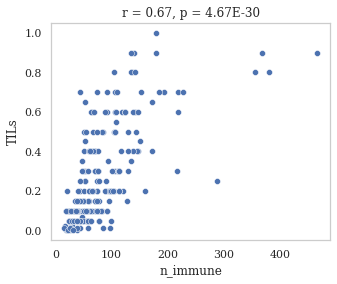

In [9]:
plot_compare(["TILs"], ["n_immune"], df_all)

In [10]:
import statsmodels.api as sm
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from numpy.linalg import LinAlgError
from statsmodels.tools.sm_exceptions import PerfectSeparationError


def _results_to_pandas(summary):
    return pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

def logit(x_train, y_train, x_val, y_val):
    try:
        model = sm.Logit(y_train, x_train).fit(disp=False)
        return model.predict(x_val)
    except (LinAlgError, PerfectSeparationError):
        return np.random.rand(*y_val.shape)
        
def logit_sklearn(x_train, y_train, x_val, y_val):
    model = LogisticRegression()
    model.fit(x_train, y_train.ravel())
    return model.predict(x_val)

def random_forest(x_train, y_train, x_val, y_val):
    model = RandomForestClassifier()
    model.fit(x_train, y_train.ravel())
    return model.predict(x_val)

def cross_validation(y, X, model = logit):
    if len(y.shape) > 1:
        y = y[:,0]
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    true, pred, = ([], [])
    summaries = []
    for train_val_idx, test_idx in cv_outer.split(X, y):
        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]

        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        for train_idx, val_idx in cv_inner.split(X_train_val, y_train_val):
            x_train, x_val = X_train_val[train_idx], X_train_val[val_idx]
            y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

            #x_train, y_train = pipeline.fit_resample(x_train, y_train)
            
            y_pred = model(x_train, y_train, x_val, y_val)
            true.extend(list(y_val))
            pred.extend(list(y_pred))
            #summaries.append(_results_to_pandas(model.summary()))
                

    #if results:
    #    print(pd.concat(summaries).groupby(level=0).mean())
        
    return true, pred

In [65]:
from itertools import combinations, chain, product, permutations
from tqdm import tqdm
from patsy import dmatrices, dmatrix
from scipy.stats import pearsonr
group = ["distant_relapse"]

features = [
    "TILs",
    "n_immune",
    "n_tumor",
    "tumor_area",
    "immune_area",
    "age",
    "nodes",
]

features.extend([
    c for c in df_all.columns 
    if c.startswith("tumor_k") 
    or c.startswith("immune_k")
    or c.startswith("t_tils")
    or c.startswith("s_tils")
])

pd.options.mode.chained_assignment = None

def _add_intercept(df):
    df = pd.DataFrame(df)
    df["Intercept"] = 1.0
    return df
    

def try_interactions(data, features, group, n_features = [1,2,3]):
    d = []
    for f in tqdm(list(chain(*[combinations(features, i) for i in n_features]))):
        f = list(f)
        nona = data[f + [group]].dropna()
        y = nona[group].values
        X = nona[f].values
        true, pred = cross_validation(y, X, logit)
        auc = roc_auc_score(true, pred)
        fpr, tpr, thresholds = roc_curve(true, pred)
        d.append({
            "formula" : '+'.join(f),
            "AUC" : auc,
            "tpr" : tpr,
            "fpr" : fpr,
            "thresh" : thresholds,
        })
            
    return pd.DataFrame(d).sort_values("AUC", ascending=False)

def best_features(df,features, target, n=10):
    result = []
    for f in features:
        y, X = dmatrices(f"{target} ~ {f}", df, NA_action='drop')
        true, pred = cross_validation(y, X, logit)
        auc = roc_auc_score(true, pred)
        result.append((f, auc))
        
    return [f[0] for f in sorted(result, key = lambda x: x[1], reverse=True)[:n]]

def filter_correlated(df, corr_limit = 0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_limit)]
    return df.drop(to_drop, axis=1)

def high_correlation(df, corr_limit):
    return [(a,b) for a, b in combinations(df.columns, 2)
            if pearsonr(*df[[a,b]].dropna().values.T)[0] > corr_limit]

def worse_predictor(df, feature_pairs, target):
    f = []
    for a, b in feature_pairs:
        f.append(min(a,b, key = lambda x: auc_formula(df, f"{target} ~ {x}")))
    return set(f)

def auc_formula(data, formula):
    y, X = dmatrices(formula, data, NA_action='drop')
    true, pred = cross_validation(y, X, logit)
    return roc_auc_score(true, pred)


In [ ]:
auc_formula(df_all[df_all["treated"]], "distant_relapse ~ n_tumor - 1")

In [66]:
def select_features(df, target, treated):
    df = df[df["treated"] == int(treated)]
    df_target = df[target]
   
    # Adding quadradic features
    
    
    ## Remvoing highly correlated interactions from 
    #f_pairs = high_correlation(df, 0.9)
    #f = df.columns
    #df[target] = df_target
    #f = set(f) - worse_predictor(df, f_pairs, target)
    
    # Computing interactions
    f = features
    df = pd.concat([
        dmatrix(f"({'+'.join(f)})**2 - 1", df, return_type='dataframe'),
        pd.concat(
        [
            df[features],
            pd.concat([df[feat]**2 for feat in f], axis=1).add_suffix("_2")
        ], axis=1)], axis=1)
    
    # Keeping the best interactions 
    f = df.columns
    df[target] = df_target
    f = best_features(df, f, target, 15)
    print(f)
    df_results = try_interactions(df, f, target, n_features=[1,2,3]) 
    df_results["Treated"] = treated
    df_results["Outcome"] = target
    return df_results.head()
#def select_features(df, target, treated):
#    df = df[df["treated"] == int(treated)]
#    df_target = df[target]
#    f = filter_correlated(df[features],  0.95).columns
#    df = dmatrix(f"({'+'.join(f)})**3 - 1", df, return_type='dataframe')
#    f = df.columns
#    df[target] = df_target
#    f = best_features(df, f, target, 20)
#    f = filter_correlated(df[f],  0.95).columns
#    df_results = try_interactions(df, f, target, n_features=[1,2,3,4]) 
#    df_results["Treated"] = treated
#    df_results["Outcome"] = target
#    return df_results.head()

In [67]:
distant_treated = select_features(df_all, "distant_relapse", treated=True)

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/env

['n_immune_2', 'immune_area_2', 'tumor_area_2', 't_tils_60_2', 'n_tumor_2', 'immune_k_200_2', 's_tils_60_2', 'TILs_2', 'tumor_area:immune_area', 'TILs:tumor_area', 'n_immune:s_tils_60', 'n_tumor:tumor_k_300', 'immune_area:s_tils_60', 'n_tumor:s_tils_60', 'age']


100%|██████████| 575/575 [00:25<00:00, 22.77it/s]


In [69]:
distant_untreated = select_features(df_all, "distant_relapse", treated=False)

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings

['s_tils_60:tumor_k_300', 'n_tumor:immune_area', 'nodes:tumor_k_300', 'immune_k_200', 's_tils_60:immune_k_200', 'n_tumor:nodes', 'age', 'TILs:immune_k_200', 'age:tumor_k_300', 'tumor_area:age', 'tumor_area:t_tils_60', 'n_tumor:age', 'age:t_tils_60', 'immune_area:immune_k_200', 'n_tumor']


/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings

In [70]:
local_treated = select_features(df_all, "local_relapse", treated=True)

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/env

['immune_k_200_2', 'immune_area_2', 'n_immune_2', 's_tils_60_2', 't_tils_60_2', 'n_tumor_2', 't_tils_60', 'n_immune', 'n_tumor:t_tils_60', 'age:tumor_k_300', 'TILs_2', 'tumor_area:immune_k_200', 'immune_area:nodes', 'n_immune:s_tils_60', 'immune_area:t_tils_60']


  5%|▍         | 28/575 [00:00<00:18, 29.44it/s]/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
 21%|██        | 118/575 [00:04<00:16, 27.98it/s]/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
 37%|███▋      | 211/575 [00:07<00:13, 26.46it/s]/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
 38%|███▊      | 217/575 [00:08<00:13, 25.72it/s]/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodel

In [71]:
local_untreated = select_features(df_all, "local_relapse", treated=False)

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/env

['n_tumor:nodes', 'nodes:t_tils_60', 'tumor_area:age', 's_tils_60', 'immune_area:s_tils_60', 'n_tumor:immune_k_200', 'tumor_area:s_tils_60', 'TILs:nodes', 'immune_k_200_2', 's_tils_60:tumor_k_300', 'n_tumor', 't_tils_60:tumor_k_300', 'n_tumor', 'age', 'n_immune:tumor_k_300']


/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 12/575 [00:00<00:14, 39.15it/s]/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 16/575

In [72]:
dead_treated = select_features(df_all, "dead", treated=True)

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/env

['age_2', 'immune_area_2', 's_tils_60_2', 'n_immune_2', 'n_tumor_2', 'tumor_area_2', 'immune_k_200_2', 't_tils_60_2', 'TILs_2', 'tumor_k_300_2', 'n_tumor:immune_k_200', 'TILs:tumor_area', 'age', 't_tils_60', 'n_immune:t_tils_60']


100%|█████████▉| 573/575 [00:19<00:00, 31.28it/s]/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 575/575 [00:19<00:00, 29.83it/s]


In [73]:
dead_untreated = select_features(df_all, "dead", treated=False)

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/arvid/.conda/env

['tumor_area:s_tils_60', 'tumor_k_300_2', 's_tils_60_2', 'n_tumor_2', 'age_2', 'immune_area_2', 'immune_area:age', 'nodes:s_tils_60', 'n_tumor', 's_tils_60', 'TILs:nodes', 'age:immune_k_200', 'n_tumor:s_tils_60', 's_tils_60', 'TILs:immune_area']


 94%|█████████▍| 541/575 [00:14<00:00, 35.02it/s]/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 96%|█████████▌| 553/575 [00:15<00:00, 27.22it/s]/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 575/575 [00:15<00:00, 36.46it/s]


immune_area_2+s_tils_60_2+immune_area:s_tils_60
s_tils_60:immune_k_200+age+age:t_tils_60
s_tils_60_2+n_tumor:t_tils_60+n_immune:s_tils_60
immune_area:s_tils_60
immune_area_2
tumor_k_300_2+n_tumor_2+immune_area_2


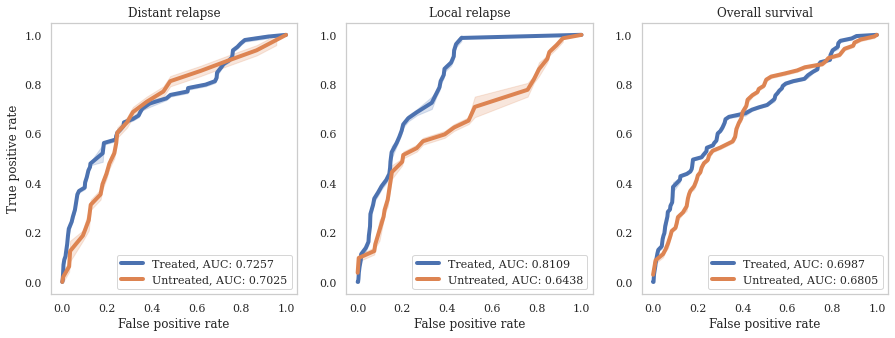

In [74]:
plt.figure(figsize=(15, 5))
plt.tight_layout()
matplotlib.rcParams['font.size'] = 20
i = 0
plt.subplot(131)
plt.title("Distant relapse")
df = distant_treated
print(df["formula"].iloc[i])
x = df["fpr"].iloc[i]
y = df["tpr"].iloc[i]
auc_treated = df["AUC"].iloc[i].round(4)
sns.lineplot(x=x, y=y, linewidth=4)
df = distant_untreated
print(df["formula"].iloc[i])
x = df["fpr"].iloc[i]
y = df["tpr"].iloc[i]
auc_untreated = df["AUC"].iloc[i].round(4)
sns.lineplot(x=x, y=y, linewidth=4)
plt.legend([f"Treated, AUC: {auc_treated}",
            f"Untreated, AUC: {auc_untreated}"])
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")


plt.subplot(132)
plt.title("Local relapse")
df = local_treated
print(df["formula"].iloc[i])
x = df["fpr"].iloc[i]
y = df["tpr"].iloc[i]
auc_treated = df["AUC"].iloc[i].round(4)
sns.lineplot(x=x, y=y, linewidth=4)
df = local_untreated
print(df["formula"].iloc[i])
x = df["fpr"].iloc[i]
y = df["tpr"].iloc[i]
auc_untreated = df["AUC"].iloc[i].round(4)
sns.lineplot(x=x, y=y, linewidth=4)
plt.legend([f"Treated, AUC: {auc_treated}",
            f"Untreated, AUC: {auc_untreated}"])
plt.xlabel("False positive rate")

plt.subplot(133)
plt.title("Overall survival")
df = dead_treated
print(df["formula"].iloc[i])
x = df["fpr"].iloc[i]
y = df["tpr"].iloc[i]
auc_treated = df["AUC"].iloc[i].round(4)
sns.lineplot(x=x, y=y, linewidth=4)
df = dead_untreated
print(df["formula"].iloc[i])
x = df["fpr"].iloc[i]
y = df["tpr"].iloc[i]
auc_untreated = df["AUC"].iloc[i].round(4)
sns.lineplot(x=x, y=y, linewidth=4)
plt.legend([f"Treated, AUC: {auc_treated}",
            f"Untreated, AUC: {auc_untreated}"])
plt.xlabel("False positive rate")
plt.savefig("../docs/outcome_roc.svg", bbox_inches='tight')

In [22]:
i = 1
plt.figure(figsize=(10, 15))
for outcome, df_outcome in df_results.groupby('Outcome'):
    for treated, df in df_outcome.groupby("Treated"):
        plt.subplot(3,2,i); i+=1
        plt.tight_layout()
        sns.lineplot(x=df["fpr"].iloc[0], y=df["tpr"].iloc[0], linewidth=4)
        plt.title(f"{outcome}, {treated}, AUC: {round(df['AUC'].iloc[0], 3)}")
        plt.ylabel("OTrue positive rate")
        plt.xlabel("False positive rate")

NameError: name 'df_results' is not defined

<Figure size 720x1080 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))
sns.set()
plt.title(f"{target}, 800 tiles")
for n, row in df_distant.iloc[:10].iterrows():
    plt.plot(*row["roc"], label=f"{round(row['AUC'],3)} {row['formula']}")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
df_all["treated"].value_counts()

In [ ]:
target = "local_relapse"
df = df_all[df_all["treated"] == 1]
df_target = df[target]
f = filter_correlated(df[features],  0.90).columns
df = dmatrix(f"({'+'.join(f)})**3 - 1", df, return_type='dataframe')
f = df.columns
df[target] = df_target
print(len(f))
f = best_features(df, f, target, 20)
f = filter_correlated(df[f],  0.95).columns
df_distant = try_interactions(df, f, target, n_features=[1,2,3,4]) 

In [ ]:
plt.figure(figsize=(8,8))
plt.title("Local relapse, 800 tiles")
for n, row in df_distant.iloc[0:20].iterrows():
    plt.plot(*row["roc"], label=f"{round(row['AUC'],3)} {row['formula']}")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
def test_samples(df_wsi, formula):
    d = []
    for frac in tqdm(np.arange(0.1,1.0,0.1)):
        for i in range(20):
            df_wsi_sample = df_wsi.groupby("image_id").sample(frac = frac)

            df = merge_patient_data_wsi(df_wsi_sample, df_pat[df_pat["treated"] == 1])
            y, X = dmatrices(formula, df, NA_action = "drop")
            true, pred = cross_validation(y, X, logit)
            auc = roc_auc_score(true, pred)
            tpr, fpr, thresholds = roc_curve(true, pred)
            d.append({
                "n_samples" : frac,
                "formula" : formula,
                "AUC" : auc,
                "roc" : (tpr, fpr),
                "thresh" : thresholds,
            })
        
    return pd.DataFrame(d)


In [ ]:
#results_distant = test_samples(df_wsi, df_distant["formula"].iloc[0])
results_distant = test_samples(df_wsi, "distant_relapse ~ n_immune")
sns.boxplot(data=results_distant, y="AUC", x="n_samples")

In [ ]:
results_local = test_samples(df_wsi, df_local["formula"].iloc[0])
plt.figure()
sns.boxplot(data=results_distant, y="AUC", x="n_samples")

In [ ]:
formula = "distant_relapse ~ n_tumor*(tumor_tils1+tumor_cluster)"
print(results_distant["formula"].iloc[0])

df_wsi_sample = df_wsi.groupby("image_id").sample(400, replace=False)
df = merge_patient_data(df_wsi_sample, df_pat[df_pat["treated"] == 1])
df = df[features + ["distant_relapse"]].replace([np.inf, -np.inf], np.nan).dropna()
y, X = dmatrices(formula, df, NA_action="drop")
true, pred = cross_validation(y, X, logit)
auc = roc_auc_score(true, pred)
tpr, fpr, thresholds = roc_curve(true, pred)
print(auc)

In [ ]:
df_all["nodes"].isna().value_counts()

In [ ]:
import os 
from shutil import copyfile
path = "../data/tnbc_wsi/images/"
for image_name in os.listdir(path):
    pat_id =  pat_id_wsi(image_name)
    if pat_id in df_pat.index and df_pat.loc[pat_id]["treated"]:
        copyfile(os.path.join(path, image_name), "../data/tnbc_wsi/treated/" + image_name)

In [ ]:
df_pat["treated"].value_counts()